# Giving context to MUSTANG-2 observer training #

[MACS J0647.8+7015](https://ned.ipac.caltech.edu/byname?objname=MACS+J0647.8%2B7015&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1) has become our de-facto target of choice. It illustrates the essentials of MUSTANG-2 observations.

In [1]:
### Useful libraries
import numpy as np
import astropy.units as u
from astropy.io import fits 
from astropy.wcs import WCS
from pathlib import Path
import os
import matplotlib.pyplot as plt
#### Modules within our library
import M2_ProposalTools.WorkHorse as WH
import M2_ProposalTools.MakeRMSmap as MRM
import M2_ProposalTools.ModelFitting as MF
import M2_ProposalTools.FilterImages as FI

Create a directory where you would like to have data from the Observer Workshop.
We can also supply immediately an output directory (for figures from this notebook).

In [2]:
basedir = "/home/data/MUSTANG2/ObserverWorkshop/"  # Assuming Linux/Mac directories
outdir = os.path.join(basedir, "Outputs")
Path(outdir).mkdir(parents=True, exist_ok=True)

You should make a local directory (e.g. `/home/data/MUSTANG2/ObserverWorkshop/`) where you can put data from the GBT Observer Workshop. You can copy some ancillary data on MACS J0647.8+7015 from the Green Bank network:
```bash
scp -r <user>@ssh.gb.nrao.edu:/home/scratch/penarray/ObserverWorkshop/MACS0647_data /home/data/MUSTANG2/ObserverWorkshop/
```

or perhaps:
```bash
rsync -avh <user>@ssh.gb.nrao.edu:/home/scratch/penarray/ObserverWorkshop/MACS0647_data /home/data/MUSTANG2/ObserverWorkshop/
```

MACS 0647 is a well-studied system. Some SZ studies focused on this system include: [Ruppin et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...615A.112R/abstract), [Romero et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...838...86R/abstract), and [Czakon et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...806...18C/abstract)

In Romero+ 2017, they adopted the mass, $M_{500}$ of $11 \times 10^{14} M_{\odot}$ from [Mantz et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010MNRAS.406.1773M/abstract)

In Ruppin+ 2018, they found several different values of $M_{500}$ (in units of $10^{14} M_{\odot}$): $7.64 \pm 0.24$, $6.95 \pm 0.56$, and $12.42 \pm 1.43$ depending on masking and inclusion of spectroscopic X-ray information.
M. Sereno reports a mass of 9.427 [Sereno (2015)](https://ui.adsabs.harvard.edu/abs/2015yCat..74503665S/abstract)

Its redshift is also reported with values between 0.584 and 0.592. NED has adopted 0.5907 as the fiducial redshift value.

For the purposes of the Observer Workshop, we do not need to reconcile all mass and redshift values -- a fiducial redshift and a rough estimate of the mass will suffice.

I will adopt a **mass ($M_{500}$) of $11.0 \times 10^{14}  M_{\odot}$ and a redshift of 0.591**.

In [3]:
M5_14    = 11.0                    # We leave this separate as we'll want to reference this below
M500     = M5_14*1e14 * u.M_sun   # in 1e14
z        = 0.591                  # The redshift
pixsize  = 2.0                    # Pixel size, in arcseconds. For MUSTANG-2, between 2" and 4" is fine.

Another item that we could calculate from our MUSTANG-2 data is the center of the cluster.
I'll include some values from the literature. Specifically, I pulled the following RA and Dec values from [Munoz et. al. (2024)](https://ui.adsabs.harvard.edu/abs/2024A%26A...682A.147M/abstract):

In [4]:
RA_CoMaLit = 101.95946
Dec_CoMaLit = 70.24861
RA_XMM = 101.95900
Dec_XMM = 70.24810

X-ray centers tend to be reliable, so I'll enter that below. Feel free to enter whatever center you want to below.

In [5]:
center = [RA_XMM, Dec_XMM]  # Example choice, don't feel beholden to this choice.

Assuming we don't already have a map of a cluster, I will make a map (with astrometry information) of a cluster.
We'll assume a spherical A10 cluster, with a pressure profile like the "disturbed" cluster subsample.

We'll say that the cluster center is the same as our pointings above. We'll further let our map go out to $5 R_{500}$, such that a given side is $10 R_{500}$. 

For use with MUSTANG-2 simulation, we'll want the input map to be beam-convolved, so we set the option to have that already done.
Finally, we can convert from Compton y to microKelvin (Rayleigh-Jeans) by setting conv2uK=True. This is nice simply because our RMS values for the sensitivity maps will be in microKelvin.

In [6]:
SkyHDU  = WH.make_A10_hdu(z, M500, pixsize, Dist=False, beamConvolve=False, conv2uK=False, center=center, nR500=5.0)

The above image is what MUSTANG-2 would see if data processing imparted no filtering effects. Unfortunately, it does, and so we combined the filtering effects with the sensitivity mapmaking in the following routine. It returns two HDULists. The first HDUList has a filtered map and a corresponding weight map, where the weight map is the inverse variance. The second HDUList is the same, but the filtered map has an additional smoothing. This smoothing is the standard smoothing applied to final MIDAS maps; it is with this smoothing that the inverse variance maps, as calculated, are appropriate comparisons.

----

Let's have a look at real data.

In [7]:
MUSTANG1_dir = os.path.join(basedir, "MACS0647_data", "MUSTANG-1")
MUSTANG2_dir = os.path.join(basedir, "MACS0647_data", "MUSTANG-2")  # If you have new data, you can change appropriately.
Bolocam_dir = os.path.join(basedir, "MACS0647_data", "Bolocam", "MACS_J0647.8+7015")

In [8]:
MUSTANG1_hdu = fits.open(os.path.join(MUSTANG1_dir, "m0647_Final_Data_Map.fits"))
M2file = "Kelvin_MACS0647_2asp_pca0_qm2_0f050-to-42f1Hz_1p0rr_L_dt20_map_iter5.fits.gz"
MUSTANG2_hdu = fits.open(os.path.join(MUSTANG2_dir, "Nov2025", "Calibrated", "Iter5", M2file))
Bolocam_hdu = fits.open(os.path.join(Bolocam_dir, "filtered_image.fits"))

In [9]:
Sky_wcs = WCS(SkyHDU[0].header)
M1_wcs = WCS(MUSTANG1_hdu[0].header)
M2_wcs = WCS(MUSTANG2_hdu[0].header)
Bo_wcs = WCS(Bolocam_hdu[0].header)

 [astropy.io.fits.verify]


In [10]:
# in arcseconds:
M1_pixsize = np.sqrt(np.abs(np.linalg.det(M1_wcs.pixel_scale_matrix))) * 3600.0
M2_pixsize = np.sqrt(np.abs(np.linalg.det(M2_wcs.pixel_scale_matrix))) * 3600.0
Bo_pixsize = np.sqrt(np.abs(np.linalg.det(Bo_wcs.pixel_scale_matrix))) * 3600.0

In [11]:
def zoom_image(ax,im,zoom,center=False,goodcen=None):
    
    myextent  = im.shape
    mycenx    = myextent[0]/2
    mylenx    = myextent[0]/2/zoom
    myceny    = myextent[1]/2
    myleny    = myextent[1]/2/zoom
    if center:
        mycenx = goodcen[0]
        myceny = goodcen[1]
    newx      = [mycenx - mylenx,mycenx + mylenx]
    newy      = [myceny - myleny,myceny + myleny]
    newextent = (newx[0],newx[1],newy[0],newy[1])
    #print(myextent,newx,newy)
    #pdb.set_trace()
    ax.set_xlim(newx)
    ax.set_ylim(newy)
        #im.set_extent(newextent)


Here, we'll just plot the "raw" images.

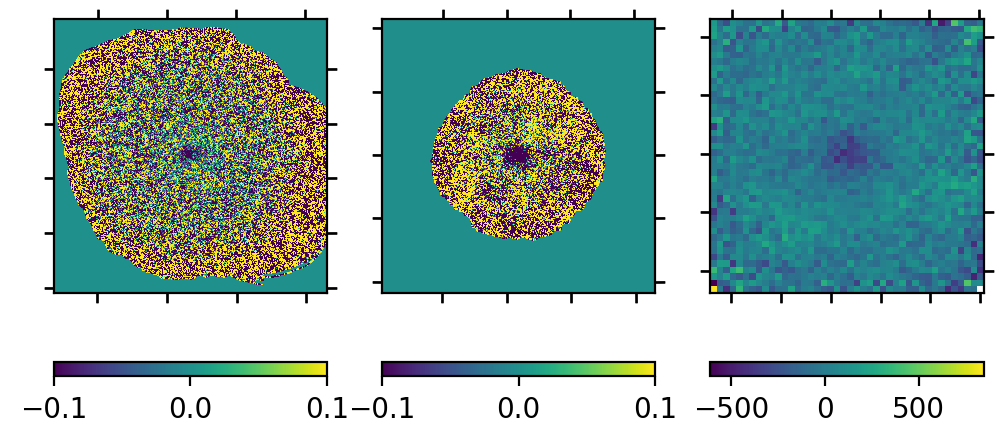

In [12]:
fig1 = plt.figure(1, figsize=(6,3), dpi=200)
fig1.clf()
ax1 = fig1.add_subplot(131, projection=M1_wcs)
im1 = ax1.imshow(MUSTANG1_hdu[0].data*1e3, origin="lower", vmin = -1e-1, vmax = 1e-1)
cb1 = fig1.colorbar(im1, orientation='horizontal')
ax1.coords[0].set_ticklabel_visible(False)
ax1.coords[1].set_ticklabel_visible(False)
ax2 = fig1.add_subplot(132, projection=M2_wcs)
im2 = ax2.imshow(MUSTANG2_hdu[0].data*1e3, origin="lower", vmin = -1e-1, vmax = 1e-1)
cb2 = fig1.colorbar(im2, orientation='horizontal')
ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
ax3 = fig1.add_subplot(133, projection=Bo_wcs)
im3 = ax3.imshow(Bolocam_hdu[0].data, origin="lower")
cb3 = fig1.colorbar(im3, orientation='horizontal')
ax3.coords[0].set_ticklabel_visible(False)
ax3.coords[1].set_ticklabel_visible(False)
fig1.savefig(os.path.join(outdir, "Naive_SZ_map_comparison.png") )

### Figure 1. 

**A _quick_ comparison of MUSTANG-1, MUSTANG-2, and Bolocam datasets on MACS J0647.8+7015**

I've omitted the tick labels because it's a bit crowded, but with them you'd quickly see the maps are not all the same size. 

Also, we've not controlled for different units used in all three maps.

----

Let's homogenize the data a bit and have a look again.

In [13]:
MUSTANG1_reproj,fp0  = MRM.reproject_fillzeros(MUSTANG1_hdu, SkyHDU[0].header)
MUSTANG2_reproj,fp1  = MRM.reproject_fillzeros(MUSTANG2_hdu, SkyHDU[0].header)
Bolocam_reproj, fp2  = MRM.reproject_fillzeros(Bolocam_hdu, SkyHDU[0].header)

 [astropy.io.fits.verify]


In [14]:
M1_conversions = np.loadtxt(os.path.join(MUSTANG1_dir, "comptony_jybeam_conversions.txt"),
                           comments="#")
M2_conversions = np.loadtxt(os.path.join(MUSTANG2_dir, "Comptony_to_K-RJ.txt"),
                           comments="#")

In [15]:
kT_e = Bolocam_hdu[0].header["T_X"]
Bolocam_conversion = Bolocam_hdu[0].header["UNIT_CON"]

In [16]:
M1_conversion = np.interp(kT_e, M1_conversions[:,0], M1_conversions[:,1])
M2_conversion = np.interp(kT_e, M2_conversions[:,0], M2_conversions[:,1])
print(M1_conversion, M2_conversion)

-2.4729144 -3.3103709153689245


In [17]:
MUSTANG1_y = MUSTANG1_reproj / M1_conversion
MUSTANG2_y = MUSTANG2_reproj / M2_conversion
Bolocam_y = Bolocam_reproj * Bolocam_conversion

In [18]:
zf = np.cbrt(M5_14) * 1.01  # Zoom factor

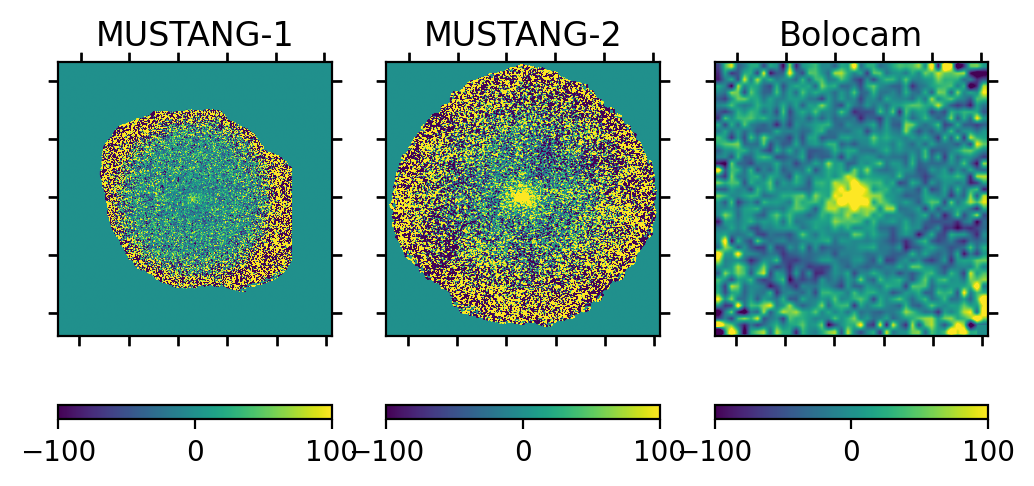

In [19]:
fig2 = plt.figure(2, figsize=(6,3), dpi=200)
fig2.clf()
ax1 = fig2.add_subplot(131, projection=Sky_wcs)
im1 = ax1.imshow(MUSTANG1_y * 1e6, origin="lower", vmin = -1e2, vmax = 1e2)
cb1 = fig2.colorbar(im1, orientation='horizontal')
ax1.coords[0].set_ticklabel_visible(False)
ax1.coords[1].set_ticklabel_visible(False)
ax1.set_title("MUSTANG-1")
zoom_image(ax1, MUSTANG1_y, zf)  # 2x zoom
ax2 = fig2.add_subplot(132, projection=Sky_wcs)
im2 = ax2.imshow(MUSTANG2_y * 1e6, origin="lower", vmin = -1e2, vmax = 1e2)
cb2 = fig2.colorbar(im2, orientation='horizontal')
ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
ax2.set_title("MUSTANG-2")
zoom_image(ax2, MUSTANG2_y, zf)  # 2x zoom
ax3 = fig2.add_subplot(133, projection=Sky_wcs)
im3 = ax3.imshow(Bolocam_y * 1e6, origin="lower", vmin = -1e2, vmax = 1e2)
cb3 = fig2.colorbar(im3, orientation='horizontal')
ax3.coords[0].set_ticklabel_visible(False)
ax3.coords[1].set_ticklabel_visible(False)
ax3.set_title("Bolocam")
zoom_image(ax3, Bolocam_y, zf)  # 2x zoom
fig2.savefig(os.path.join(outdir, "Comptony_map_comparison.png") )

### Figure 2. 

**A _homogenized_ comparison of MUSTANG-1, MUSTANG-2, and Bolocam datasets on MACS J0647.8+7015**

The tick labels are still omitted, but we had regridded all the maps to the same astrometry and same units.

----

But the maps look different. We can also do a quick verification (or at least something a bit more quantitative than looking at a colored image) and produce radial plots.

In [20]:
SkyMap = SkyHDU[0].data * 1.0

In [21]:
rbin0, ybin0, yerr0, ycnts0 = MF.extract_radial_profile(SkyHDU, arcmin=True)
SkyHDU[0].data = MUSTANG1_y*1e6
rbin1, ybin1, yerr1, ycnts1 = MF.extract_radial_profile(SkyHDU, arcmin=True)
SkyHDU[0].data = MUSTANG2_y*1e6
rbin2, ybin2, yerr2, ycnts2 = MF.extract_radial_profile(SkyHDU, arcmin=True)
SkyHDU[0].data = Bolocam_y*1e6
rbin3, ybin3, yerr3, ycnts3 = MF.extract_radial_profile(SkyHDU, arcmin=True)

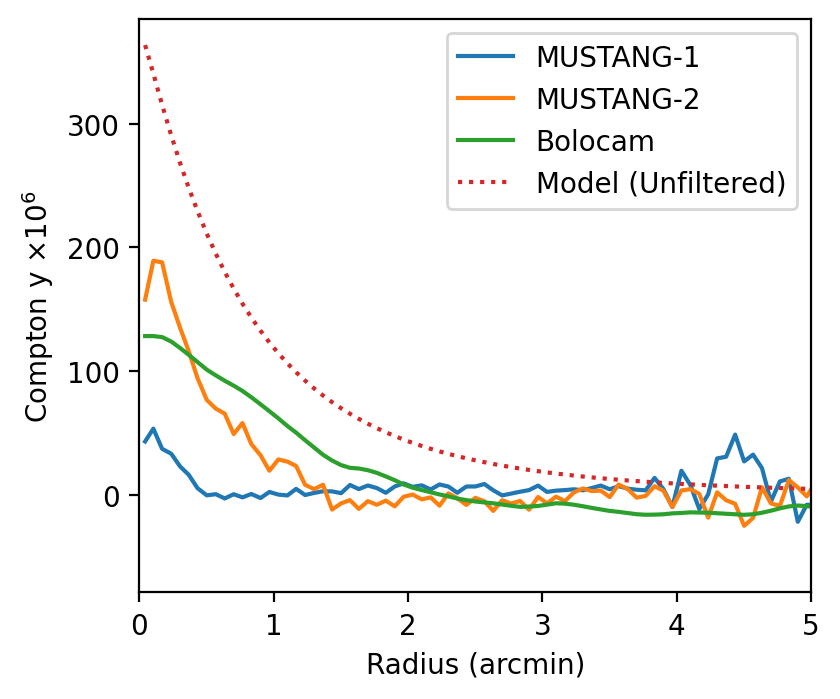

In [22]:
fig3 = plt.figure(3, figsize=(4.3, 3.6), dpi=200)
rax = fig3.add_subplot(111)
rax.plot(rbin1, ybin1, label = "MUSTANG-1")
rax.plot(rbin2, ybin2, label = "MUSTANG-2")
rax.plot(rbin3, ybin3, label = "Bolocam")
rax.plot(rbin0, ybin0*1e6, label = "Model (Unfiltered)", linestyle=":")
rax.set_xlabel("Radius (arcmin)")
rax.set_ylabel(r"Compton y $\times 10^6$")
rax.set_xlim([0,5.0])
rax.legend()
fig3.tight_layout()
fig3.savefig(os.path.join(outdir, "Comptony_profile_MACS0647_data_comparison.png") )

### Figure 3.

**A comparison of Compton-y MUSTANG-1, MUSTANG-2, Bolocam, and a model radial profiles on MACS J0647.8+7015**

----

OK, this confirms the datasets show different surface brightnesses. Why is that?

## Image filtering

A few main factors that modulate the surface brightness of a single-dish continuum image are:

1. The beam size (shape)
2. The field of view of the instrument
3. How the data is processed

----

We'll see below that most single-dish SZ instruments have calculated a **transfer function**, which is generally just the quantification of the transmission in the Fourier domain. Specifically, the convention is to supply the transmission of the Fourier transform (and not its absolute square, i.e. power spectrum). Sometimes the transfer function is given assuming radial symmetry; other places it is given as a 2D array.

Let's start with the MUSTANG-2 filtering. As this Python package was made for MUSTANG-2 observers to simulate MUSTANG-2 observations of a given target, much of the MUSTANG-2 specific information is under-the-hood.

P.S. The `WIKID` keyword refers to a potential successor to MUSTANG-2. I.e. one could simulate an observation with that (currently hypothetical) instrument.

In [23]:
M2_bmconv = WH.smooth_by_M2_beam(SkyMap, pixsize=pixsize)  # Beam-convolved image
scan_size = 3.5 # Scan size; the transfer function has a slight dependence on scan size.
MUSTANG2_sky = WH.lightweight_filter_ptg(M2_bmconv, scan_size, pixsize, WIKID=False)

OK, now we can calculate the filtering for MUSTANG-1 using some of the more fundamental functions.

In [24]:
MUSTANG1_xfer = os.path.join(MUSTANG1_dir, "m0647_xfer_fxn_srcsz_180.txt")
M1_tab = FI.get_xfer(MUSTANG1_xfer)
# MUSTANG-1 had a slightly different beamshape than MUSTANG-2
M1_bmconv = WH.smooth_by_M2_beam(SkyMap, pixsize=pixsize, inst="MUSTANG")
MUSTANG1_sky = FI.apply_xfer(M1_bmconv,  M1_tab, pixsize)

Finally Bolocam requires a bit more work. The transfer function is given in a 42x42 pixel image, so we need to match the astrometry to the original image and take its FFT. Otherwise, the steps are the same.

In [25]:
#Bolocam_xfer = os.path.join(basedir, )
Bolocam_xhdu = fits.open(os.path.join(Bolocam_dir, "filtered_image_signal_transfer_function.fits"))
Bolocam_tab = Bolocam_xhdu[0].data
Bo_bmconv = WH.smooth_by_M2_beam(SkyMap, pixsize=pixsize, inst="BOLOCAM")
SkyHDU[0].data = Bo_bmconv * 1.0 # Without the 1e6 multiplication above
Sky_reproj_Bolocam, fpb  = MRM.reproject_fillzeros(SkyHDU, Bolocam_hdu[0].header)
Bolocam_sky = FI.apply_xfer(Sky_reproj_Bolocam, Bolocam_tab, Bo_pixsize, tabdims='2D')
Bolocam_hdu[0].data = Bolocam_sky * 1.0  # Overwrite the transfer function file
Bolocam_reproj_sky, fpb2  = MRM.reproject_fillzeros(Bolocam_hdu, SkyHDU[0].header)

 [astropy.io.fits.verify]


### Compare model images



In [26]:
def im_plot(fig, axes, ari, aci, img, vmin=-1e2, vmax=1e2, title="Default", zoom=1, make_cb=True,
           cb_orientation='horizontal', cb_location="top"):

    myax = axes[ari, aci]
    im_sky = myax.imshow(img, origin="lower", vmin = vmin, vmax = vmax)
    #cax = fig.add_axes([0.35, 0.94, 0.31, 0.02])
    if make_cb:
        fig.delaxes(axes[0,0])
        cax = fig.add_subplot(2, 3, 1) 
        #cax = axes[0,0]
        cax.set_position([0.35, 0.94, 0.31, 0.02])
        #cax.xaxis.set_ticks_position('top')
        #cax.coords[0].set_ticklabel_visible(False)
        #cax.coords[1].set_ticklabel_visible(False)
        cax.set_yticks([])
        cb_sky = fig.colorbar(im_sky, cax=cax, orientation="horizontal", location="top")
        #cb_sky = fig.colorbar(im_sky, orientation="horizontal")
        #cax.yaxis.set_visible(False)
    myax.coords[0].set_ticklabel_visible(False)
    myax.coords[1].set_ticklabel_visible(False)
    ax3.set_title("Bolocam")
    if zoom > 1:
        zoom_image(myax, img, zoom)  # 2x zoom    

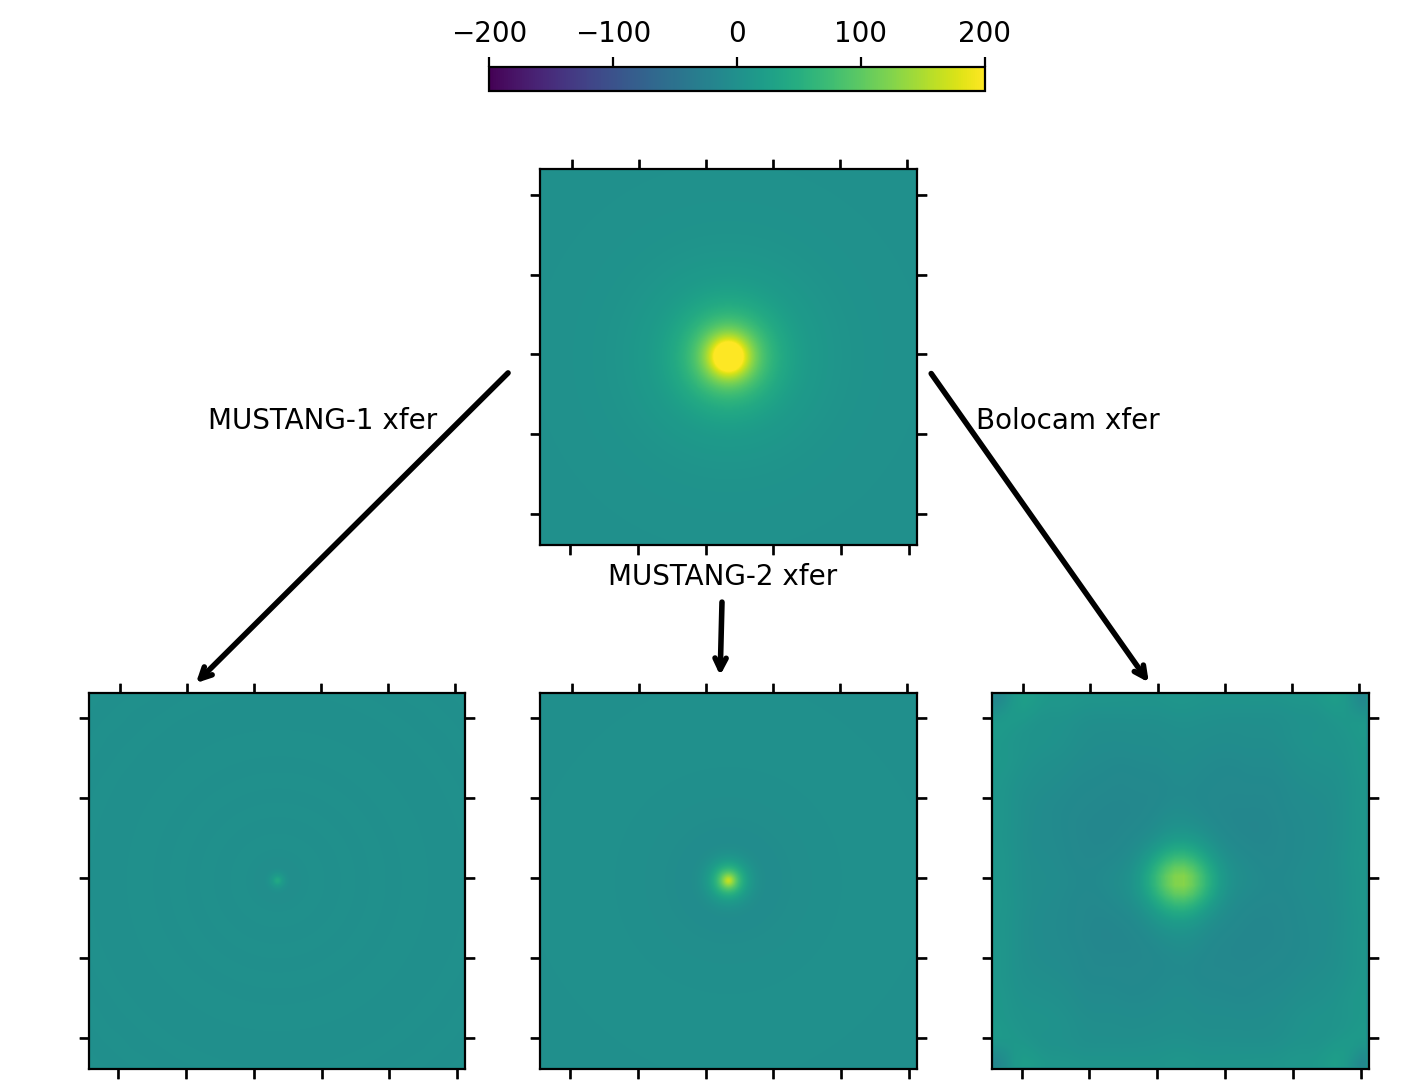

In [27]:
fig, axs = plt.subplots(
    nrows=2, ncols=3,
    figsize=(8,6),
    constrained_layout=False,
    subplot_kw={'projection': Sky_wcs},
    dpi=200
)

fig.subplots_adjust(
    left=0.1,
    right=0.9,     
    bottom=0.1,
    top=0.90,        # leave room for colorbar
    wspace=0.20,
    hspace=0.2,
)

fig.delaxes(axs[0,2]) # Remove the existing axes object
#---------------------------------------------------------------------
vmin = -2e2
vmax = 2e2
im_plot(fig, axs, 0, 1, SkyMap*1e6, vmin=vmin, vmax=vmax, title="A10 model", zoom=zf, make_cb=True,
       cb_orientation='horizontal', cb_location="top")
im_plot(fig, axs, 1, 0, MUSTANG1_sky*1e6, vmin=vmin, vmax=vmax, title="MUSTANG-1 model", zoom=zf, make_cb=False)
im_plot(fig, axs, 1, 1, MUSTANG2_sky*1e6, vmin=vmin, vmax=vmax, title="MUSTANG-2 model", zoom=zf, make_cb=False)
im_plot(fig, axs, 1, 2, Bolocam_reproj_sky*1e6, vmin=vmin, vmax=vmax, title="Bolocam model", zoom=zf, make_cb=False)
#fig.delaxes(axs[0,0]) # Remove the existing axes object

# Manually override things.
axs[0,1].annotate("", xy=(0.12, 0.335), xytext = (0.32, 0.6),
            xycoords="figure fraction", textcoords="figure fraction",
            arrowprops=dict(arrowstyle="->",lw=2,color="black") )
axs[0,1].annotate("MUSTANG-1 xfer", xy=(0.05, 0.5), xytext = (0.13, 0.55),
            xycoords="figure fraction", textcoords="figure fraction",
            arrowprops=dict(arrowstyle="->",lw=2,color="white") )
axs[0,1].annotate("MUSTANG-2 xfer", xy=(0.45, 0.34), xytext = (0.38, 0.42),
            xycoords="figure fraction", textcoords="figure fraction",
            arrowprops=dict(arrowstyle="->",lw=2,color="black") )
axs[0,1].annotate("", xy=(0.72, 0.335), xytext = (0.58, 0.6),
            xycoords="figure fraction", textcoords="figure fraction",
            arrowprops=dict(arrowstyle="->",lw=2,color="black") )
axs[0,1].annotate("Bolocam xfer", xy=(0.92, 0.5), xytext = (0.61, 0.55),
            xycoords="figure fraction", textcoords="figure fraction",
            arrowprops=dict(arrowstyle="->",lw=2,color="white") )
fig.savefig(outdir+"Model_and_simulated_models_MACS0647.png")

### Figure 4.

**A comparison by way of a flowchart. Or rather, a visual explanation of why MUSTANG-1, MUSTANG-2, and Bolocam have images that look fairly different (for being the same target, and observing *roughly* the same sky signal).

----

Let's once again look to a radial plot to have a better handle on how this approach did.

In [28]:
SkyHDU[0].data = MUSTANG1_sky*1e6
rbin4, ybin4, yerr4, ycnts4 = MF.extract_radial_profile(SkyHDU, arcmin=True)
SkyHDU[0].data = MUSTANG2_sky*1e6
rbin5, ybin5, yerr5, ycnts5 = MF.extract_radial_profile(SkyHDU, arcmin=True)
SkyHDU[0].data = Bolocam_reproj_sky*1e6
rbin6, ybin6, yerr6, ycnts6 = MF.extract_radial_profile(SkyHDU, arcmin=True)

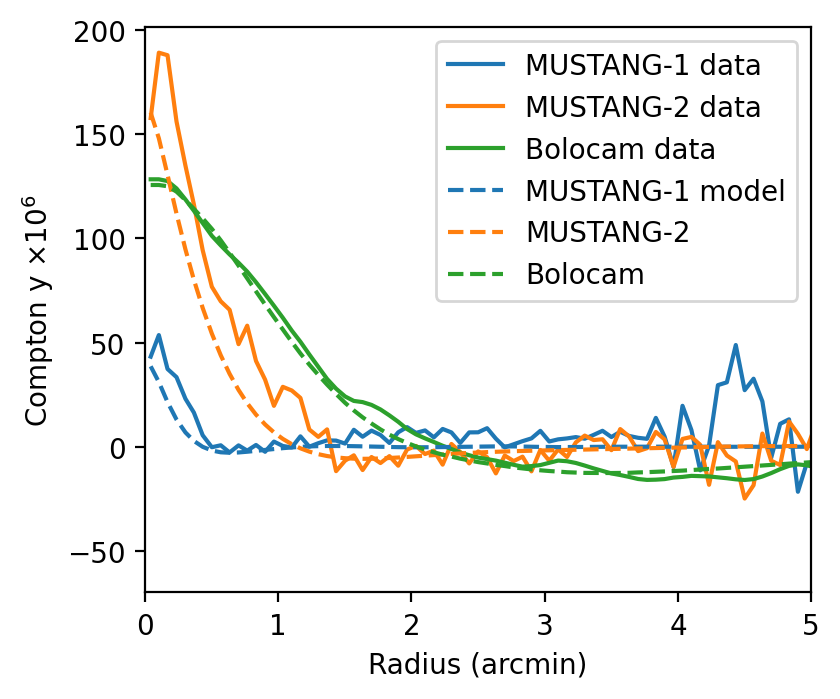

In [29]:
fig3 = plt.figure(3, figsize=(4.3, 3.6), dpi=200)
rax = fig3.add_subplot(111)
rax.plot(rbin1, ybin1, label = "MUSTANG-1 data")
rax.plot(rbin2, ybin2, label = "MUSTANG-2 data")
rax.plot(rbin3, ybin3, label = "Bolocam data")
rax.plot(rbin4, ybin4, label = "MUSTANG-1 model", color="C0", linestyle = "--")
rax.plot(rbin5, ybin5, label = "MUSTANG-2", color="C1", linestyle = "--")
rax.plot(rbin6, ybin6, label = "Bolocam", color="C2", linestyle = "--")
rax.set_xlabel("Radius (arcmin)")
rax.set_ylabel(r"Compton y $\times 10^6$")
rax.set_xlim([0,5.0])
rax.legend()
fig3.tight_layout()
fig3.savefig(os.path.join(outdir, "Comptony_profile_MACS0647_model_data_comparison.png") )

### Figure 5.

**A comparison of Compton-y MUSTANG-1, MUSTANG-2, and Bolocam data and forward-modeled radial profiles on MACS J0647.8+7015**

## Conclusions, considerations for the trainees

If you study the intracluster medium (ICM), you may already start to think about the physical implications. While this is good, I should caution the observer that it is best to consider any systematic issues (perhaps oversights) that could account for remaining disparities. 

1. What are some of the disparities that you note in Figure 5.?
2. What are some *potential* oversights in this quick analysis?

## Beyond this template notebook:

* You should try to load in any MUSTANG-2 data you have produced.
  - Why might there be discrepancies with the new data?
  - (I would expect there to be greater disparaties with the new data).
* You might also consider plotting (and comparing) the transfer functions of MUSTANG-1, MUSTANG-2, and Bolocam.
**Hint:** For Bolocam, the pixels are $20^{\prime\prime}$, and you can use $k^2 = k_x^2 + k_y^2$ to get a transfer function in 1D.
* In a related, but separate, train of thought (specifically comparing filtered images to unfiltered images), you might also look at the unfiltered Bolocam image. NB the Bolocam [README](https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/bolocam/Bolocam_public_data_README.txt).
